# Simulation d'un circuit d'autobus

## Introduction

Je me suis amusé à créer une petite simulation d'un circuit d'autobus, `roadsim`.  Un circuit est composé d'arrêts à des positions déterminées.  Des passagers arrivent aux arrêts selon un processus aléatoire précisé par l'usager, et des autobus parcourent le circuit en transportant les passagers.  Ce simulateur est volontairement très simple, mais il permet néanmoins de faire plusieurs mesures intéressantes.

Dans ce billet, je présenterai le fonctionnement du simulateur et j'expliquerai les paramètres par défaut de la simulation.

Le code complet est disponible sur [Github](https://github.com/loicseguin/roadsim).

## Exemple

Tout d'abord, voici comment exécuter une simulation.  Il est possible de n'utiliser que les valeurs par défaut, mais pour illustrer la façon de spécifier les variables aléatoires, je modifie certains paramètres.

In [1]:
import numpy as np
from buslinesim import Simulation
from scipy.stats import truncnorm

stop_pos = np.arange(0, 30, 2)
nb_stops = len(stop_pos)
mean_stops = nb_stops/2.0
std_stops = nb_stops/4.0
stops_to_dest = lambda: np.round(truncnorm.rvs(-1, 1, loc=mean_stops, scale=std_stops))
sim = Simulation(bus_stop_positions=stop_pos,
                 time_between_buses=lambda: 20,
                 nb_stops_to_dest=stops_to_dest,
                 passenger_arrival_times=lambda : np.random.exponential(3.0),
                 nb_buses=20)
sim.run()

Un fois la simulation terminée, il est possible d'obtenir plusieurs statistiques et des graphiques en utilisant la propriété `stats` de la simulation.

Mean satisfaction: 0.8784343993113631
Mean number of passengers per bus: 100.6


c:\Users\elblo\Desktop\Universidad\Hackaton-SM\python\buslinesim.py:444: RuntimeWarning: Mean of empty slice.
  avg_nb_passengers = [nb_passengers.mean()
c:\Users\elblo\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\core\_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


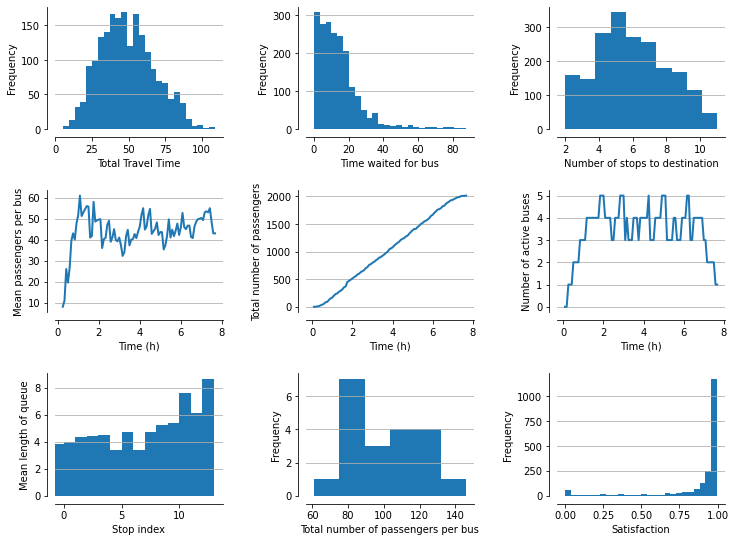

In [2]:
print('Mean satisfaction:', np.mean(sim.stats.satisfaction))
print('Mean number of passengers per bus:', np.mean(sim.stats.total_passengers[-1]))
sim.stats.plot()

Pour un planificateur, ces simulations peuvent aider à déterminer le prix d'un billet d'autobus et la fréquence de passage des autobus.  Plus la fréquence est élevée, plus les clients sont satisfait, mais plus les coûts d'opération augmentent.  En ajustant les paramètres de la simulation, on peut arriver à trouver un compromis entre la profitabilité et la qualité du service.

Voici un vidéo de la simulation qui montre la position des autobus (triangles rouges) et la longueur des queues à chaque arrêt.  La taille d'un triangle rouge donne une indication du nombre de passagers dans l'autobus : plus le triangle est gros, plus il y a de passagers.

In [3]:
from IPython.display import HTML
from base64 import b64encode
video = open("movie.mp4", "rb").read()
video_encoded = b64encode(video)
video_tag = '<video controls alt="test" src="data:video/x-m4v;base64,{0}" type="video/mp4">'.format(video_encoded)
HTML(data=video_tag)

FileNotFoundError: [Errno 2] No such file or directory: 'movie.mp4'

## Arrêts et arrivées des passagers

Un **circuit** est composé d'une suite d'**arrêts**.  La position de chaque arrêt est la distance entre l'arrêt en question et le premier arrêt du circuit.  Par exemple, pour 10 arrêts également espacés de 2 km, il suffit de définir les positions comme

In [4]:
bus_stop_positions = np.arange(0, 20, 2)

Évidemment, il est aussi possible de définir les positions de n'importe quelle autre façon.  Le plus intéressant serait probablement d'utiliser les distances réelles entre les arrêts de votre ligne d'autobus préférée.  Par défaut, `roadsim` utilise les positions suivantes

In [5]:
bus_stop_positions = np.arange(0, 30, 3)

soit 10 arrêts également espacés de 3 km.

Les passagers entrent dans le système lorsqu'ils arrivent à un arrêt.  Les arrivées se produisent selon un processus aléatoire qui est identique pour tous les arrêts.  Autrement dit, il n'y a pas d'arrêt plus achalandé que d'autres, ce qui n'est pas très réaliste.  Le code pourrait être modifié assez facilement pour permettre de spécifier des processus différents à chaque arrêt.

Le processus aléatoire régissant les arrivées est fourni au simulateur par une fonction qui échantillonne le temps entre deux arrivées successives.  Par exemple, si les passagers arrivent selon un processus de Poisson de paramètre \\(\lambda\\), le temps entre deux arrivées successives est une variable aléatoire exponentielle de paramètre \\(\lambda\\).  Il faut donc fournir au simulateur une fonction qui, chaque fois qu'elle est appelée, retourne une valeur choisie selon la fonction de densité d'une exponentielle \\(\lambda\\).  Si un passager arrive toutes les cinq minutes en moyenne, alors la fonction

In [6]:
passenger_arrival_times = lambda: np.random.exponential(5.0)

est appropriée.  Les arrivées peuvent être décrites par n'importe quel processus aléatoire, pas seulement un processus de Poisson.  Pour une arrivée toute les 5 minutes, on peut utiliser

In [7]:
passenger_arrival_times = lambda: 5

Par défaut, les arrivées suivent un processus de Poisson avec une arrivée chaque 10 minutes, en moyenne.

Lorsqu'un nouveau passager arrive à un arrêt, il se place à la queue derrière les passagers déjà présents.  Le premier passager arrivé sera le premier à monter à bord d'un autobus.  Les passagers à chaque arrêt sont donc dans une queue de type *first in, first out* (FIFO).

La **source** d'un passager est le numéro de l'arrêt auquel il est arrivé.  La **destination** du passager est obtenue en ajoutant à la source une variable aléatoire qui correspond au nombre d'arrêts jusqu'à la destination.  Cette variable aléatoire doit donc être entière et supérieure ou égale à 1 (un passager doit se rendre au moins jusqu'au prochain arrêt).  La destination peut être plus grande que le numéro du dernier arrêt du circuit, mais dans ce cas, le passager sera tout de même obligé de descendre de l'autobus au dernier arrêt.  La valeur par défaut est

In [8]:
nb_stops_to_dest = lambda: np.round(truncnorm.rvs(-1, 4, loc=4, scale=3))

## Autobus

Le nombre d'autobus dans la simulation est fixé au départ.  Un autobus commence son parcours au premier arrêt, puis avance d'arrêt en arrêt.  Lorsqu'il arrive à un arrêt, les passagers qui sont rendus à leur destination descendent de l'autobus, puis les passagers qui attendaient à l'arrêt montent dans l'autobus.  Le temps pour qu'un passager monte dans l'autobus est une variable aléatoire dont la valeur par défaut est

In [9]:
hop_in_time = lambda: truncnorm.rvs(-1, 8, loc=0.3, scale=0.2)

c'est-à-dire que le temps moyen pour embarquer est environ 18 secondes avec un écart type de 12 secondes.  La distribution est asymétrique car on peut supposer que la majorité des passagers montent rapidement, mais il y a quelques passagers (des personnes agées, des enfants ou des personnes avec un handicap physique) qui prennent plus de temps pour monter à bord.

Le temps pour descendre de l'autobus est aussi une variable aléatoire dont la distribution par défaut est la même que celle pour monter dans l'autobus.

Entre deux arrêts, on suppose qu'un autobus se déplace à vitesse constante.  Par contre, la vitesse entre chaque paire d'arrêts peut être différente.  Cette vitesse est déterminée par une variable aléatoire.  Par défaut, la vitesse est normale (tronquée) de moyenne 49.8 km/h et d'écart type 6 km/h :

In [10]:
bus_speed = lambda: truncnorm.rvs(-2, 2, loc=0.83, scale=0.1)

Le temps entre l'arrivée de deux autobus successifs au premier arrêt du circuit est donnée par une variable aléatoire.  Par défaut, les autobus arrivent au premier arrêt à chaque 25 minutes

In [11]:
time_between_buses = lambda: 25

mais il est possible d'utiliser n'importe quelle autre distribution.

## Satisfaction des passsagers

Afin d'évaluer la performance du circuit et de l'horaire des départs d'autobus, la simulation mesure la **satisfaction** des clients.  Un client sera mécontent s'il doit attendre l'autobus longtemps.  Une fois qu'il est dans l'autobus, on suppose que la durée du trajet n'influence pas son appréciation du service.  Un modèle simple est de supposer que la satisfaction d'un client est une fonction sigmoïde sur une échelle de 0 (très insatisfait) à 1 (très satisfait) :

\\[S(t) = \frac{1}{2} \left(1 - \tanh\left(\frac{1}{10}(t - \gamma )\right)\right).\\]

Par exemple, pour $\gamma = 30$ minutes, la fonction de satisfaction ressemble à ceci.

Text(0, 0.5, 'Satisfaction')

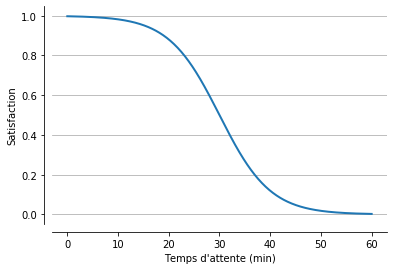

In [12]:
import matplotlib.pyplot as plt
from buslinesim import PrettyFig
x = np.linspace(0, 60, 500)
y = 0.5 * (1 - np.tanh(0.1*(x - 30)))
fig = plt.figure(FigureClass=PrettyFig)
plt.plot(x, y, linewidth=2)
plt.xlabel("Temps d'attente (min)")
plt.ylabel("Satisfaction")

La fonction de satisfaction ne peut pas être spécifiée dans les options de la simulation, mais il est facile de la modifier directement dans le code.  Elle est définie par la méthode `satisfy` de la classe `Passenger`.